# Allenamento del modello

#### Importiamo le librerie utili

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,ConvLSTM2D,LSTM,BatchNormalization,Flatten,Conv2D,MaxPooling2D
from tensorflow.keras.activations import softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


from sklearn.metrics import r2_score

from warnings import filterwarnings
filterwarnings('ignore')

#### Carichiamo i dati

In [2]:
(X_train,y_train),(X_test,y_test)=mnist.load_data()

#### Manipoliamo i dati

<i> Questo lo facciamo perchè dobbiamo creare un terzo valore fittizio nella dimensione del dataset mnist, quello che faremo sarà:</i> 
* normalizzare le varibili, 
* il reshape delle variabili.

In [3]:
def pre_process(X):
    X=X/X.max() # cosi normalizziamo
    return X.reshape(-1,28,28,1) # cosi cambiamo la dimensione delle immagini da bianco e nero a colori

In [4]:
X_train=pre_process(X_train)
X_test=pre_process(X_test)

#### Ordiniamo le variabili y

<i> L'ordinamento sfrutterà il one hot encoding che in keras si esegue con to_categorial </i>

In [5]:
y_train_ohe=to_categorical(y_train)
y_test_ohe=to_categorical(y_test)

#### Creiamo un generatore di immagini

In [6]:
datagen=ImageDataGenerator(rotation_range=90,width_shift_range=0.9,zoom_range=0.5,validation_split=0.3)
train=datagen.flow(x=X_train,y=y_train_ohe,batch_size=64,seed=42)

In [7]:
train.dtype

'float32'

#### Definiamo il modello della nostra rete neurale

In [8]:
def neural_model ():
    model = Sequential()
    
    model.add(Conv2D(filters=64, kernel_size=(2,2), activation='relu', input_shape=(28, 28, 1))) #input_dim=train.shape[1]
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(filters=128,kernel_size=(2,2), activation='relu')) #input_dim=train.shape[1]
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,kernel_size=(2,2), activation='relu')) #input_dim=train.shape[1]
    model.add(BatchNormalization()) 
    model.add(MaxPooling2D(pool_size=(1,1)))
              
    model.add(Flatten())
              
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=100, activation="relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=50, activation="relu"))
    model.add(Dropout(rate=0.5))

    model.add(Dense(units=10, activation="softmax"))

    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics="categorical_accuracy")

    return model

In [9]:
Conv_lstm=neural_model()
Conv_lstm.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 27, 27, 64)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 27, 27, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 128)       32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         1

> ###### EarlyStopping

Durante l'addestramento del modello, è possibile fermare la fase di training nel caso in cui il modello non dovesse migliorare con l'avanzare delle epoche.

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', min_delta=1e-5,patience=10,mode='min',restore_best_weights=True)

> ##### ModelCheckpoint

Utilizziamo il model checkpoint in modo da poter salvare i migliori risultati del modello, è una forma di sicurezza in quanto le reti possono impiegare molto tempo ad allenarsi, sfortunatamente in quel momento per motivi x si potrebbe spegne il pc.

In [11]:
model_checkpoint=ModelCheckpoint(filepath='/models/temp/checkpoints',
                                 save_best_only=True, save_weights_only=True, 
                                 monitor='val_categorical_accuracy', mode='max')

#### Fitiamo il modello 

In [12]:
history=Conv_lstm.fit_generator(generator=train,callbacks=[early_stopping, model_checkpoint],epochs=500,
                               validation_data=(X_test, y_test_ohe))

Epoch 1/500
938/938 [==============================] - 60s 63ms/step - loss: 2.3972 - categorical_accuracy: 0.1179 - val_loss: 2.1598 - val_categorical_accuracy: 0.2121
Epoch 2/500
938/938 [==============================] - 59s 63ms/step - loss: 2.2338 - categorical_accuracy: 0.1618 - val_loss: 1.7656 - val_categorical_accuracy: 0.5032
Epoch 3/500
938/938 [==============================] - 59s 63ms/step - loss: 2.1133 - categorical_accuracy: 0.2180 - val_loss: 1.2688 - val_categorical_accuracy: 0.6104
Epoch 4/500
938/938 [==============================] - 59s 63ms/step - loss: 1.9662 - categorical_accuracy: 0.2799 - val_loss: 0.8380 - val_categorical_accuracy: 0.7100
Epoch 5/500
938/938 [==============================] - 59s 63ms/step - loss: 1.8414 - categorical_accuracy: 0.3292 - val_loss: 0.5733 - val_categorical_accuracy: 0.8247
Epoch 6/500
938/938 [==============================] - 59s 63ms/step - loss: 1.7277 - categorical_accuracy: 0.3780 - val_loss: 0.5478 - val_categorical_acc

938/938 [==============================] - 64s 68ms/step - loss: 1.2336 - categorical_accuracy: 0.5781 - val_loss: 0.1922 - val_categorical_accuracy: 0.9456
Epoch 50/500
938/938 [==============================] - 59s 63ms/step - loss: 1.2225 - categorical_accuracy: 0.5805 - val_loss: 0.1964 - val_categorical_accuracy: 0.9444


#### Vediamo graficamente i risultati del modello

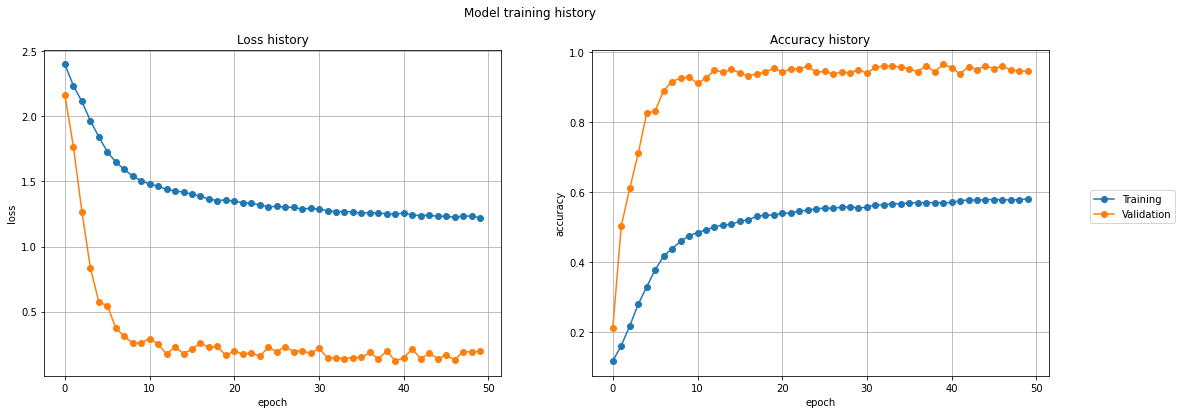

In [13]:
# define figure and axes
fig = plt.figure(figsize=(18, 6))
ax = fig.subplots(nrows=1, ncols=2)

histories = Conv_lstm.history.history

fig.suptitle("Model training history")
# first axes options
ax[0].set_title("Loss history")
ax[0].plot(histories["loss"], marker="o")
ax[0].plot(histories["val_loss"], marker="o")
ax[0].grid()
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
# second axes options
ax[1].plot(histories["categorical_accuracy"], marker="o")
ax[1].plot(histories["val_categorical_accuracy"], marker="o")
ax[1].set_title("Accuracy history")
ax[1].grid()
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
fig.legend(["Training", "Validation"], loc=5)
plt.show()

In [15]:
r2_score(histories["categorical_accuracy"],histories["val_categorical_accuracy"])

-12.973826504119128

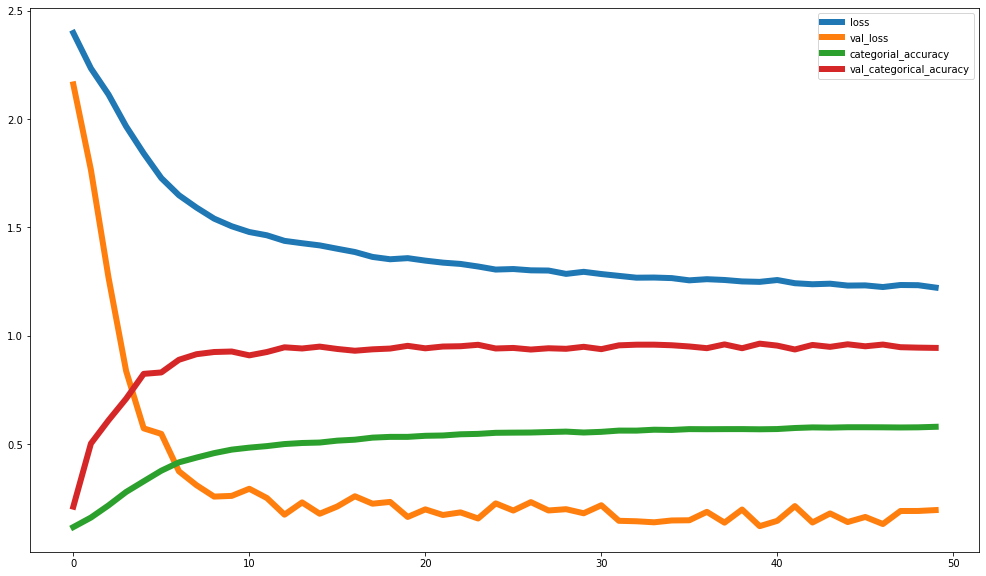

In [18]:
fig = plt.figure(figsize=(17, 10))
ax = fig.subplots()
pd.DataFrame(histories["loss"]).plot(linewidth=6,ax=ax)
pd.DataFrame(histories["val_loss"]).plot(linewidth=6,ax=ax)
pd.DataFrame(histories["categorical_accuracy"]).plot(linewidth=6,ax=ax)
pd.DataFrame(histories["val_categorical_accuracy"]).plot(linewidth=6,ax=ax)
ax.legend(["loss","val_loss", "categorial_accuracy", "val_categorical_acuracy",])
fig.show()

#### Carico i checkpoint che hanno ottenuto i migliori pesi

In [20]:
Conv_lstm.load_weights(filepath='/models/temp/checkpoints')

In [ ]:
#### In fine slavo il modello di rete neurale ottenuto

In [21]:
Conv_lstm.save("models/model.h5")